# シンプルな3層のCNNを実装する

Tensorflowの関数を使い、2層の畳み込み→Relu→Max Poolingと、1層の全層結合を実装してmnistに対して精度を検証します。

# 事前作業

必要なライブラリをインポートします。

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

セッションの生成

In [2]:
sess = tf.Session()

mnistデータセットの読み込み

In [20]:
data_dir = 'temp'
mnist = read_data_sets(data_dir)

Extracting temp/train-images-idx3-ubyte.gz
Extracting temp/train-labels-idx1-ubyte.gz
Extracting temp/t10k-images-idx3-ubyte.gz
Extracting temp/t10k-labels-idx1-ubyte.gz


取得したトレーニングデータの形状を確認します。

In [4]:
mnist.train.images[0].shape

(784,)

合わせてラベル（正解データ）も確認します。

In [5]:
mnist.train.labels[0]

7

### 問1 取得したトレーニングデータから画像をピックアップし、確認してください。

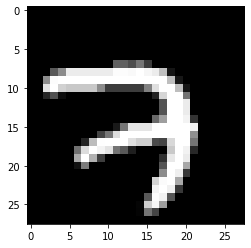

In [6]:
img = np.reshape(mnist.train.images[0], (28, 28))
plt.imshow(img, cmap='gray')
plt.show()

### 問2 np.reshapeを用い、画像を (784,)から(28,28)に変換してください

(55000, 28, 28, 1)


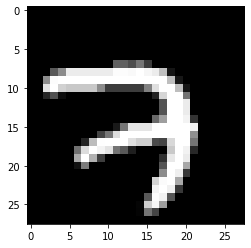

In [7]:
train_x = np.reshape(mnist.train.images, (55000, 28, 28, 1))
print(train_x.shape)
plt.imshow(train_x[0, :, :, 0], cmap='gray');

ラベルデータを変数train_Yに格納します。

In [8]:
train_y = mnist.train.labels

プレースホルダを作成します。

In [9]:
batch_size = 100
x_input = tf.placeholder(tf.float32, shape=(batch_size, 28, 28, 1))
y_target = tf.placeholder(tf.float32, shape=(batch_size))

### 問3 CNNの構築

* 1層目のCNN・・・フィルタ数:25、フィルタサイズ：4、ストライド：(1,1)、ゼロパディングなし('SAME')

* 2層目のCNN・・・フィルタ数:50、フィルタサイズ：4、ストライド：(1,1)、ゼロパディングなし('SAME')

とし、 `tf.layers.conv2d` および `tf.layers.max_pooling2d` を使って2層のCNNを作成してください。

In [10]:
learning_rate = 0.005
filter_size = 4
conv1_filters = 25
conv2_filters = 50
max_pool_size1 = 2
max_pool_size2 = 2

In [21]:
conv1 = tf.layers.conv2d(inputs=x_input, filters=conv1_filters, kernel_size=filter_size, strides=(1, 1), padding="same", activation=tf.nn.relu)
print(conv1.shape)
pool_1 = tf.layers.max_pooling2d(conv1, max_pool_size1, strides=(2, 2), padding='same', data_format='channels_last')
print(pool_1.shape)

conv2 = tf.layers.conv2d(inputs=pool_1, filters=conv2_filters, kernel_size=filter_size, strides=(1, 1), padding="same", activation=tf.nn.relu)
print(conv2.shape)

pool_2 = tf.layers.max_pooling2d(conv2, max_pool_size2, strides=(2, 2), padding='same', data_format='channels_last')

(?, 28, 28, 25)
(?, 14, 14, 25)
(?, 14, 14, 50)


### 問4 pool_2の形状を確認してください

In [12]:
print(pool_2.shape)

(100, 7, 7, 50)


### 問5  pool_2を2次元の形状に変換してください。ただし1次元はバッチサイズとします。

変換後のサイズは(100,2450)となります。

In [13]:
flat = tf.reshape(pool_2, [100, 2450])

### 問6 問5にて2次元に変換したものを入力とし、出力が10となる全層結合層を作成してください。

結果は(100,10)となります。

In [22]:
logits = tf.layers.dense(flat,10, activation=tf.nn.relu)

交差エントロピー誤差を求めます。

In [23]:
loss = tf.losses.sparse_softmax_cross_entropy(labels=tf.cast(y_target, dtype=tf.int32), logits=logits)

### 問7 TensorFlowのAPIには sparse_softmax_cross_entropyのほかにsoftmax_cross_entropyがあります。両者の違いを述べてください。

**sparse_softmax_cross_entropy**  
sparse(疎な)の名の通り, 入力を自動で one-hot ベクトルにする.

**softmax_cross_entropy**  
one-hot ベクトルにしない.

### 問8 モーメンタムオプティマイザを指定し、誤差を最小化するグラフを作成してください。

In [16]:
optimizer = tf.train.MomentumOptimizer(momentum=0.9 ,learning_rate=learning_rate)
train_op = optimizer.minimize(loss)

### 問9 softmax関数を使用し、logitsから予測値を導き出してください。

In [17]:
init = tf.global_variables_initializer()
sess.run(init)

rand_index = np.random.choice(55000, 100)
rand_x = train_x[rand_index]
rand_y = train_y[rand_index]

sess.run(train_op, feed_dict={x_input:rand_x, y_target:rand_y})

# グラフの実行

グラフの初期化を行います。

### 問10 イテレーション回数を1000とし、20回ごとに損失を表示するトレーニングを実行してください。

In [18]:
for i in range(100):
    rand_index = np.random.choice(55000, batch_size)
    batch_xs = train_x[rand_index]
    batch_ys = train_y[rand_index]
    sess.run(train_op, feed_dict={x_input: batch_xs, y_target: batch_ys})

    if (i+1) % 20 == 0:
        print('Loss #'+str(i+1)+" loss = "+str(sess.run(loss, feed_dict={x_input:rand_x, y_target:rand_y})))

Loss #20 loss = 2.2455997
Loss #40 loss = 2.1596777
Loss #60 loss = 2.0258303
Loss #80 loss = 1.8632847
Loss #100 loss = 1.6257412


### 問12  訓練データで訓練後、テストデータを与えて精度を確認してください。さらに、データセットからランダムに値をピックアップし、学習結果が正しいかどうかを検証してください。

ただし、x_input, y_targetともにバッチサイズ100に固定した形でplaceholderを作ったため、検証データもサイズが100でないとエラーとなります。

placeholderのshapeタプル内のbatchsizeをNone（無指定）に変更して再トレーニングする必要があります。

Extracting temp/train-images-idx3-ubyte.gz
Extracting temp/train-labels-idx1-ubyte.gz
Extracting temp/t10k-images-idx3-ubyte.gz
Extracting temp/t10k-labels-idx1-ubyte.gz
正解ラベル # [8 1 1]
1枚目


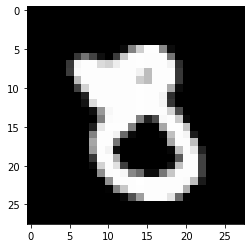

2枚目


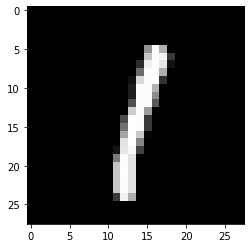

3枚目


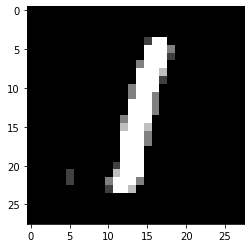

Loss # 20 loss = 2.214501
Loss # 40 loss = 1.9586554
Loss # 60 loss = 1.1273932
Loss # 80 loss = 0.53745776
Loss # 100 loss = 0.43435585
Loss # 120 loss = 0.40456527
Loss # 140 loss = 0.3972853
Loss # 160 loss = 0.36159906
Loss # 180 loss = 0.28956926
Loss # 200 loss = 0.18390955
Loss # 220 loss = 0.37845135
Loss # 240 loss = 0.28296134
Loss # 260 loss = 0.19092146
Loss # 280 loss = 0.2548842
Loss # 300 loss = 0.24414101
Loss # 320 loss = 0.21681546
Loss # 340 loss = 0.26167879
Loss # 360 loss = 0.18193778
Loss # 380 loss = 0.113713846
Loss # 400 loss = 0.15751645
Loss # 420 loss = 0.26150888
Loss # 440 loss = 0.14873594
Loss # 460 loss = 0.15561007
Loss # 480 loss = 0.19761653
Loss # 500 loss = 0.2382841
Loss # 520 loss = 0.13660452
Loss # 540 loss = 0.2515588
Loss # 560 loss = 0.12680583
Loss # 580 loss = 0.1018495
Loss # 600 loss = 0.23752004
Loss # 620 loss = 0.17540659
Loss # 640 loss = 0.13016225
Loss # 660 loss = 0.23728842
Loss # 680 loss = 0.174106
Loss # 700 loss = 0.06638110

In [19]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets

# データ読み込み
data_dir = 'temp'
mnist = read_data_sets(data_dir)

# プレースホルダーを用意
x_input = tf.placeholder(tf.float32, shape=(None, 28, 28, 1))
y_target = tf.placeholder(tf.int64, shape=(None))

# 初期設定
batch_size = 100
learning_rate = 0.005
filter_size = 4
conv1_filters = 25
conv2_filters = 50
max_pool_size1 = 2
max_pool_size2 = 2

# 畳み込み①→プーリング①→畳み込み②→プーリング②
conv1 = tf.layers.conv2d(inputs=x_input, filters=conv1_filters, kernel_size=filter_size, strides=(1, 1), padding="same", activation=tf.nn.relu)
pool_1 = tf.layers.max_pooling2d(conv1, max_pool_size1, strides=(2, 2), padding='same', data_format='channels_last')
conv2 = tf.layers.conv2d(inputs=pool_1, filters=conv2_filters, kernel_size=filter_size, strides=(1, 1), padding="same", activation=tf.nn.relu)
pool_2 = tf.layers.max_pooling2d(conv2, max_pool_size2, strides=(2, 2), padding='same', data_format='channels_last')

# プーリング②からの出力を2次元配列にして全結合層へ
flat = tf.reshape(pool_2, [-1, 2450])
logits = tf.layers.dense(flat,10)

# 損失関数の定義
loss = tf.losses.sparse_softmax_cross_entropy(labels=tf.cast(y_target, dtype=tf.int32), logits=logits)

# オプティマイザの指定
optimizer = tf.train.MomentumOptimizer(momentum=0.9 ,learning_rate=learning_rate)
train_op = optimizer.minimize(loss)

# 精度の算出
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_target, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))

# テストデータの準備
test_x = np.reshape(mnist.test.images, (10000, 28, 28, 1))
test_y_one_hot = np.identity(10)[mnist.test.labels]

# サンプルデータの準備
sample_n = 3
sample_id = np.random.choice(55000, sample_n)
sample_x = np.reshape(mnist.train.images[sample_id], (sample_n, 28, 28, 1))
sample_y = mnist.train.labels[sample_id]
sample_y_one_hot = np.identity(10)[sample_y]

print('正解ラベル # ' + str(sample_y))

# サンプルデータを画像に
sample_imgs = np.reshape(mnist.train.images[sample_id], (sample_n, 28, 28)) 
for i in range(sample_n):
    img = sample_imgs[i]
    print(str(i+1) + '枚目') 
    plt.imshow(img, cmap='gray')
    plt.show()

# セッション初期化
init = tf.global_variables_initializer()
with tf.Session() as sess:
    init.run()
    # イテレーションを1000回として学習
    for iteration in range(1000):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch = np.reshape(X_batch, (batch_size, 28, 28, 1))
            sess.run(train_op, feed_dict={x_input: X_batch, y_target: y_batch})
            
            # 20回ごとに損失関数の値を表示
            if (iteration+1) % 20 == 0:
                print('Loss # '+str(iteration+1)+" loss = "+str(sess.run(loss, feed_dict={x_input:X_batch, y_target:y_batch})))
    
    # テストデータで精度を算出
    print ('test accuracy' +str(accuracy.eval(feed_dict={x_input: test_x, y_target: test_y_one_hot})))
    print ('予測した正解ラベル # ' +str(sess.run(tf.argmax(logits, 1), feed_dict={x_input:sample_x, y_target:sample_y})))